
<img src="https://github.com/Yorko/mlcourse.ai/blob/main/img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Виталий Радченко, Data scientist @ YouScan (@vradchenko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 5 (Демо).
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

[Веб-форма](https://docs.google.com/forms/d/1HASy2b_FLBHBCzzpG-TbnbB6gqhB-qwznQxU2vaoSgc/) для ответов.

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [1]:
import sklearn.linear_model
%matplotlib inline
# отключим предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [2]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [3]:
## Считываем данные
data = pd.read_csv("https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [4]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

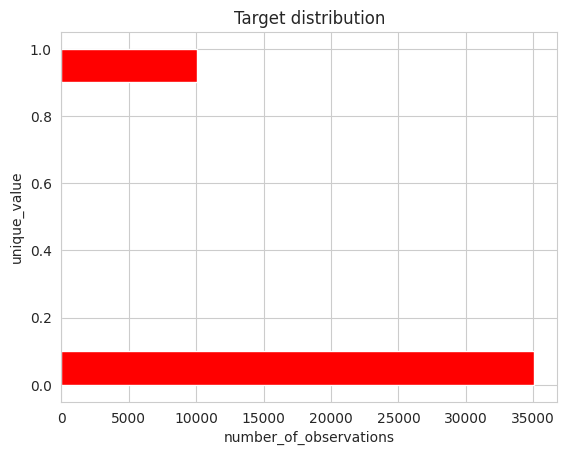

In [5]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [6]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [7]:
data.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,3.642000e+04,43946.000000
mean,0.222489,51.210949,0.750993,352.062688,0.570712,0.505870,6.452263e+03,0.789628
std,0.415922,14.651533,6.184521,2467.556358,6.173106,6.153609,1.263817e+04,1.130813
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,40.000000,0.000000,0.176373,0.000000,0.000000,3.286000e+03,0.000000
50%,0.000000,51.000000,0.000000,0.373949,0.000000,0.000000,5.166000e+03,0.000000
75%,0.000000,62.000000,0.000000,0.857027,0.000000,0.000000,8.000000e+03,1.000000
max,1.000000,107.000000,98.000000,326442.000000,98.000000,98.000000,1.794060e+06,10.000000


In [8]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [9]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [10]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
SeriousDlqin2yrs_False = data[data.SeriousDlqin2yrs == False]['age'].values
SeriousDlqin2yrs_True= data[data.SeriousDlqin2yrs == True]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample)
                       for sample in get_bootstrap_samples(SeriousDlqin2yrs_True, 1000)]
churn_mean_scores = [np.mean(sample)
                       for sample in get_bootstrap_samples(SeriousDlqin2yrs_False, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from True:  mean interval",  stat_intervals(loyal_mean_scores, 0.1))
print("Service calls from False:  mean interval",  stat_intervals(churn_mean_scores, 0.1))

Service calls from True:  mean interval [45.71379414 46.12700479]
Service calls from False:  mean interval [52.59470132 52.85480064]


## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [25]:
### Ваш код должен быть здесь ###
lr_grid_search = GridSearchCV(lr, param_grid=parameters, scoring='roc_auc')
ls_best_score = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr_grid_search.fit(X_train, y_train)
    ls_best_score.append(lr_grid_search.best_score_)
    print(f'best_params:', lr_grid_search.best_params_)
    print(f'best_score:', lr_grid_search.best_score_)
    print(f'best_score_test:', lr_grid_search.score(X_test, y_test))

print(ls_best_score)

best_params: {'C': 0.1}
best_score: 0.8007884831034492
best_score_test: 0.7917008278390781
best_params: {'C': 0.1}
best_score: 0.8026184584438703
best_score_test: 0.7939326555187374
best_params: {'C': 0.1}
best_score: 0.8089989417288033
best_score_test: 0.798565912082505
best_params: {'C': 1}
best_score: 0.8080513926508821
best_score_test: 0.806268864729855
best_params: {'C': 10}
best_score: 0.8114935002570904
best_score_test: 0.8010352668350531
[0.8007884831034492, 0.8026184584438703, 0.8089989417288033, 0.8080513926508821, 0.8114935002570904]


**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [27]:
### Ваш код должен быть здесь ###
np.std(ls_best_score)

0.004030236580903997

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [43]:
### Ваш код должен быть здесь ###
from sklearn.preprocessing import Normalizer

X_normalize = Normalizer(norm='l2', copy=False).fit_transform(X)
name_columns = X.columns
X_normalize = pd.DataFrame(X_normalize, columns=name_columns)
X_normalize.head(10)

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0.007845,0.000000,3.063255e-05,0.0,0.0,0.999969,0.00000
1,0.008985,0.000000,5.995295e-01,0.0,0.0,0.800302,0.00000
2,0.006150,0.000000,6.842460e-05,0.0,0.0,0.999981,0.00000
3,0.004095,0.000000,1.809509e-08,0.0,0.0,0.999992,0.00019
4,0.121591,0.000000,6.745078e-04,0.0,0.0,0.992580,0.00000
5,0.006156,0.000000,3.634115e-05,0.0,0.0,0.999981,0.00000
6,0.011363,0.000000,2.151775e-04,0.0,0.0,0.999935,0.00000
7,0.007605,0.000000,4.272448e-06,0.0,0.0,0.999971,0.00000
8,0.005163,0.000279,3.261330e-05,0.0,0.0,0.999987,0.00000
9,0.014665,0.000000,1.122423e-04,0.0,0.0,0.999892,0.00000


In [60]:
lr_5 = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
lr_5.fit(X_normalize, y)

LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [57]:
print(lr_5.coef_)

[[-0.02784443  0.00959598 -0.13080021  0.00952868  0.00850392  0.07473117
   0.00101068]]


**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [15]:
### Ваш код должен быть здесь ###

**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [16]:
### Ваш код должен быть здесь ###

# Случайный лес

In [61]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [63]:
### Ваш код должен быть здесь ###
rf_grid_search = GridSearchCV(rf, param_grid=parameters, scoring='roc_auc')
rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_)
print(rf_grid_search.best_params_)

0.8355017850041773
{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [66]:
### Ваш код должен быть здесь ###
rf_best = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, oob_score=True, class_weight="balanced", max_depth=10, max_features=2, min_samples_leaf=9)
rf_best.fit(X, y)
rf_best.feature_importances_

array([0.11585997, 0.30028969, 0.0760817 , 0.27874902, 0.15653442,
       0.05799435, 0.01449085])

In [67]:
X.head(5)

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,64,0,0.249908,0,0,8158.0,0.0
1,58,0,3870.000000,0,0,5166.0,0.0
2,41,0,0.456127,0,0,6666.0,0.0
3,43,0,0.000190,0,0,10500.0,2.0
4,49,0,0.271820,0,0,400.0,0.0


**Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

# Бэггинг

In [70]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [76]:
### Ваш код должен быть здесь ###
base_est = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
bag_cls = BaggingClassifier(random_state=42, base_estimator=base_est, n_estimators=100)
bag_rs_CV= RandomizedSearchCV(bag_cls, n_jobs=-1, n_iter=20, param_distributions=parameters, cv=5, random_state=1)
bag_rs_CV.fit(X, y)
print(bag_rs_CV.best_params_)
print(bag_rs_CV.best_score_)

/home/Nikolay/PycharmProjects/ODSml/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/Nikolay/PycharmProjects/ODSml/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

{'max_samples': 0.9, 'max_features': 4, 'base_estimator__C': 1}
0.8152586422856485


**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации